# Clasificación de texturas

En algunos problemas de visión artificial el objetivo es reconocer diferentes tipos de imagen que no tienen forma ni color definido, ni puntos de interés (keypoints) reproducibles.

![tex1](../images/demos/tex1.png)

![tex2](../images/demos/tex2.png)

Si tienen ciertas regularidades o estructuras repetitivas podemos intentar un ataque mediante el análisis de [texturas](https://en.wikipedia.org/wiki/Image_texture). 

## Local Binary Patterns

Vamos a experimentar con el descriptor de textura [LBP](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) (Local Binary Pattern). La idea es calcular un histograma de los diferentes tipos de entorno local que hay en una región. Fíjate en la imagen siguiente. El trocito rojo pequeño de la izquierda se ve ampliado en el centro. Vamos a fijarnos en el pixel central del recuadro verde. A este pixel le vamos a asignar un código en función de su entorno local. Tiene a su alrededor 8 pixels, que vamos a convertir en ceros (=negro) o unos (=blanco) según sean más oscuros o más claros que el pixel central. Esto se muestra en el recuadro verde de la derecha. Debajo ponemos los bits ordenados de izquierda a derecha y de arriba a abajo (quitando el central). Pasando a decimal tenemos el código asignado al pixel central, que en este caso el el 43.

![lbp1](../images/demos/lbp/lbp1.png)

A continuación se muestran otros ejemplos. Observa los códigos binarios que se obtienen de los niveles de gris. Como se basan en la comparación de mayor/menor el código es bastante independiente de la iluminación y da un resultado que está relacionado con el tipo de borde y su orientación. 

![lbp2](../images/demos/lbp/lbp2.png)

![lbp3](../images/demos/lbp/lbp3.png)

![lpb4](../images/demos/lbp/lbp4.png)

Este código se calcula para todos los pixels de una región de interés. Como hay 8 bits en el entorno 3x3 que hemos considerado, hay 256 códigos posibles. (El código puede guardarse en una imagen de byte como las monocromas que estamos utilizando. Pero su visualización como imagen no es fácil de interpretar.)

Vamos a caracterizar un ROI con el histograma de estos códigos, con una caja para cada posible valor. Comparando estos histogramas podemos distinguir texturas. En este notebook vamos a experimentar con esta idea.

Como siempre, preparamos unas cuantas utilidades.

In [1]:
import numpy as np
import cv2   as cv

import matplotlib.pyplot as plt
%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread('../images/'+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

Opencv tiene una implementación de LBP, pero aquí usarmos la de scikit-image, que es muy configurable y admite ciertas variantes del método. Los puntos del entorno se toman en un círculo a una cierta distancia, en vez de ser los 8 del entorno cuadrado que hemos mostrado antes, pero el efecto es muy similar.

In [2]:
from skimage.feature import local_binary_pattern

Lo probamos en una imagen cualquiera, ampliando mucho una región:

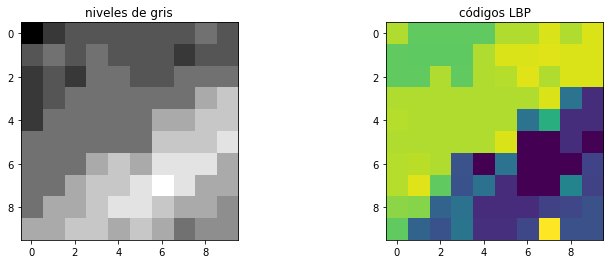

In [3]:
img = rgb2gray(readrgb('coins.png'))

lbp = local_binary_pattern(img,8,5)  # número de puntos, radio

fig(12,4)
plt.subplot(1,2,1)
plt.imshow(img[300:310,300:310],'gray', interpolation='nearest')
plt.title('niveles de gris')
plt.subplot(1,2,2)
plt.imshow(lbp[300:310,300:310],interpolation='nearest')
plt.title('códigos LBP');

Como hemos explicado más arriba, son códigos binarios para cada posible configuración de entornos de pixel 3x3, teniendo en cuenta si cada pixel es más o menos oscuro que el centro.

In [4]:
lbp[:5,:5]

array([[193., 193., 193., 193.,  97.],
       [193., 193.,  65.,  65.,  96.],
       [193.,  64.,  64.,  64.,  96.],
       [192.,  64.,   0.,   0.,  96.],
       [192.,   0.,   0.,  64.,  32.]])

La "textura" de una región de la imagen (o de toda ella) se puede describir mediante un histograma de estos códigos.

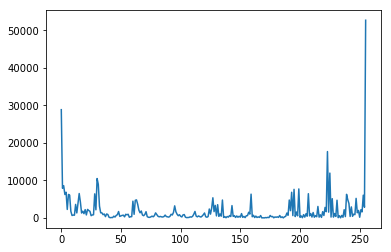

In [5]:
hlbp, _b = np.histogram(lbp, bins=np.arange(257))
plt.plot(hlbp);

Creamos una función con las operaciones anteriores:

In [6]:
# calcula el código LBP de cada pixel en un trozo de imagen y hace un histograma de ellos
def feature(x):
    g = rgb2gray(x)
    h,w = g.shape
    lbp = local_binary_pattern(g,8,5)
    d = 10  # descartamos un borde de 10 pixels
    h,b = np.histogram(lbp[d:-d,d:-d], bins=256, range=(0,256))
    s = np.sum(h)
    return h/s

En primer lugar experimentamos con una pequeña colección de imágenes de texturas:

    wget https://robot.inf.um.es/material/va/texturas.tar.gz
    
(En la carpeta `images/texturas` del repositorio hay un script que automatiza la descarga).

Como no son muchas imágenes podemos guardarlas todas en una lista, emparejadas con su nombre de archivo:

In [7]:
import glob

texs = [ (file, readrgb(file)) for file in sorted(glob.glob('../images/texturas/simple/*.*')) ]

In [8]:
len(texs)

59

Veamos una de ellas.

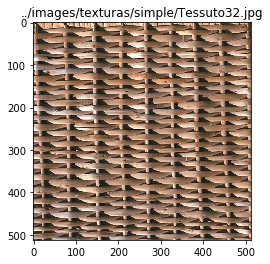

In [9]:
n = 47
plt.imshow(texs[n][1]); plt.title(texs[n][0]);

Calculamos los histogramas LPB de todas ellas:

In [10]:
vs = [feature(t[1]) for t in texs]

Y mostramos el de la imagen anterior.

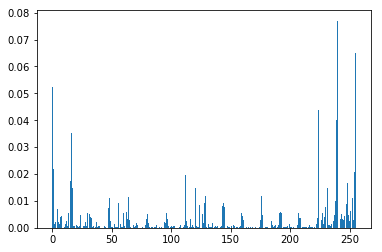

In [11]:
plt.bar(range(256),vs[n]);

La siguiente función encuentra las imágenes más parecidas a una de ellas.

In [12]:
import numpy.linalg as la

# dado un elemento k, busca el más parecido en la lista, (que no sea él mismo)
def check(k,vs):
    vk = vs[k]
    ds = [ (la.norm(v-vk), m) for m,v in enumerate(vs) if m != k ]
    return sorted(ds)

Cambiando la variable `t` en la celda siguiente elegimos la textura que queremos comparar y mostramos las dos más parecidas.

[(0.004356567511330948, 7),
 (0.012478717507730835, 2),
 (0.014498402408315347, 1),
 (0.01518052170995204, 31),
 (0.01518052170995204, 52)]

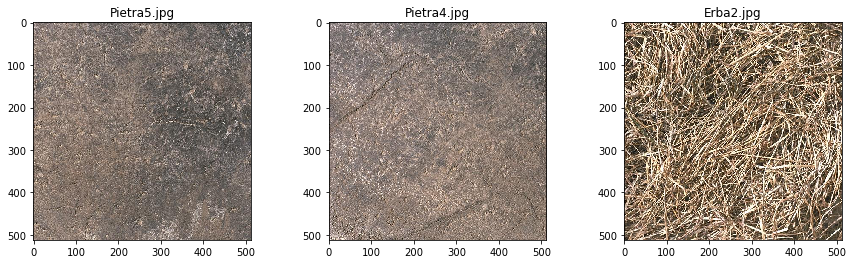

In [13]:
t = 8
r = check(t,vs)[:5]  # nos quedamos con las 5 mejores

y = r[0][1]
z = r[1][1]
fig(15,4)
plt.subplot(1,3,1); plt.imshow(texs[t][1]); plt.title(texs[t][0][26:]);
plt.subplot(1,3,2); plt.imshow(texs[y][1]); plt.title(texs[y][0][26:]);
plt.subplot(1,3,3); plt.imshow(texs[z][1]); plt.title(texs[z][0][26:]);

r

La segunda mejor está mucho más alejada.

[(0.0, 18),
 (0.013592403673368595, 29),
 (0.013592403673368595, 50),
 (0.01569360228547246, 14),
 (0.01569360228547246, 20)]

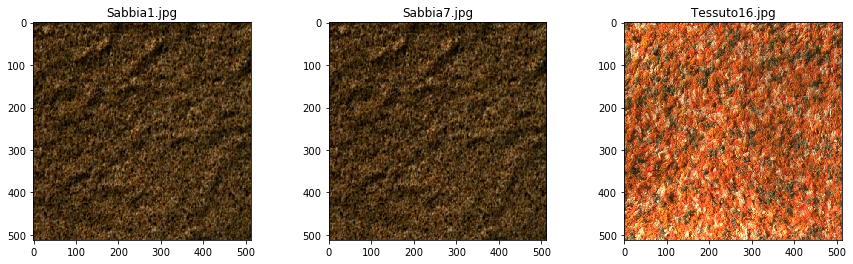

In [14]:
t = 10
r = check(t,vs)[:5]

y = r[0][1]
z = r[1][1]
fig(15,4)
plt.subplot(1,3,1); plt.imshow(texs[t][1]); plt.title(texs[t][0][26:]);
plt.subplot(1,3,2); plt.imshow(texs[y][1]); plt.title(texs[y][0][26:]);
plt.subplot(1,3,3); plt.imshow(texs[z][1]); plt.title(texs[z][0][26:]);

r

La diferencia cero exacta indica que hay imágenes repetidas. Esta base de datos no es muy buena. Vamos a utilizar una colección de texturas más completa (ya se ha descargado automáticamente con el script anterior).

    wget https://robot.inf.um.es/material/va/curetgrey.zip
    
Esta colección tiene varias muestras de cada tipo de textura, con diferentes condiciones de iluminación y otros cambios. Echa un vistazo a la carpeta para ver las imágenes disponibles.

En este caso guardamos directamente la "feature" para no tener en memoria las 5.6K imágenes de la colección. (Pero entonces luego habrá que leer otra vez con `readrgb` las imágenes que queramos mostrar.)

In [15]:
# no es instantáneo...
texs = [ (file, feature(readrgb(file))) for file in sorted(glob.glob('../images/texturas/curetgrey/*/*.*')) ]

In [16]:
len(texs)

5612

In [17]:
vs = [t[1] for t in texs]

[(0.007325680839084842, 2315),
 (0.0075152895010174425, 2322),
 (0.007532002545011403, 2366),
 (0.007696270947410895, 2347),
 (0.0078848209144868, 2384)]

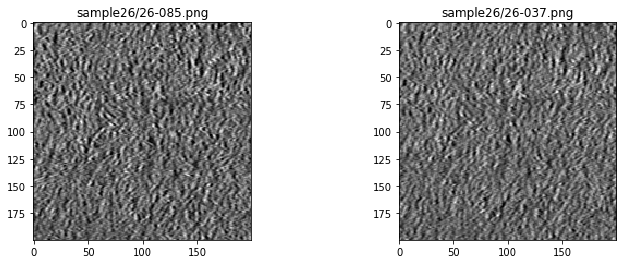

In [18]:
t = 2345
r = check(t,vs)[:5]

y = r[0][1]

fig(12,4)
plt.subplot(1,2,1); plt.imshow(readrgb(texs[t][0])); plt.title(texs[t][0][29:]);
plt.subplot(1,2,2); plt.imshow(readrgb(texs[y][0])); plt.title(texs[y][0][29:]);

r

Encuentra correctamente muestras de la misma textura.

El método es interesante pero tiene limitaciones. Por ejemplo, no es invariante a escala ni a rotaciones. Pero es muy sencillo y eficiente y puede ser útil en situaciones donde las condiciones de captura están controladas.